Реализация PINN на pytorch взята отсюда: https://github.com/jayroxis/PINNs/blob/master/Burgers%20Equation/Burgers%20Inference%20(PyTorch).ipynb

#Уравнение второго порядка:

коэффициенты

In [34]:
import math
n=1
a=1.
alpha=1.
beta=1.
k=1.
z0=-40.
th0=0.
w=9/8
l = (4. * alpha * n ** 2) / (a + n * a)
nu = (4. * beta * n ** 2) / (a + 2. * n * a)
mu = (4. * n ** 2 * (w - a * k ** 2)) / a

решение

In [35]:
def q(x,t):
  const = math.exp((x-2*a*k*t-z0)*math.sqrt(mu))
  return [math.pow(((4*mu) / ((1/const)+2*l+(l**2-4*mu*nu)*const)), 1/(2*n)) * math.cos(k*x-w*t+th0),
  math.pow(((4*mu) / ((1/const)+2*l+(l**2-4*mu*nu)*const)), 1/(2*n)) * math.sin(k*x-w*t+th0)]

In [36]:
!pip install pyDOE

In [37]:
import torch
from collections import OrderedDict #упорядоченный словарь
from pyDOE import lhs #функция, выбирающая значения для обучения на них нейросети
import numpy as np
import time
np.random.seed(1234)

In [38]:
#можно сменить среду выполнения на gpu и обучение будет происходить быстрее
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [39]:
def q_tensor(x,t): #тензорная функция q, принимающая на вход тензоры из координат x и t и возвращающая тензоры из u и v
  const = torch.exp((x-2*a*k*t-z0)*math.sqrt(mu))
  return [torch.pow(((4*mu*const) / (1+2*l*const+(l**2-4*mu*nu)*const**2)), 1/(2*n)) * torch.cos(k*x-w*t+th0),
                             torch.pow(((4*mu*const) / (1+2*l*const+(l**2-4*mu*nu)*const**2)), 1/(2*n))*torch.sin(k*x-w*t+th0)]

In [40]:
class SinActivation(torch.nn.Module): #кастомная функция активации - sin
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)

нейросеть, в виде которой будет находиться решение

In [41]:
class DNN(torch.nn.Module):
    def __init__(self, layers): #принимает на вход массив целых чисел
        super(DNN, self).__init__() #вызывает метод init(почему нельзя сделать это без super?)

        self.depth = len(layers) - 1
        self.activation = SinActivation #в качестве функции активации используется tanh

        layer_list = list() #список с весами и функциями активации для каждого слоя
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])) #каждые два слоя образуют двудольный граф
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])) #нельзя сделать в цикле, потому что нет функции активации
        )

        layerDict = OrderedDict(layer_list) #сделали упорядоченный словарь, чтобы при использовании элементы выдавались в том порядке, в котором были добавлены

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict) #собственно, задали архитектуру нейросети

    def forward(self, x):
        out = self.layers(x)
        return out

наконец, PINN

In [42]:
class PhysicsInformedNN():
    def __init__(self, X_uv, u, v, X_f, layers, lb, ub, a, alpha, beta):

        # граничные условия
        self.lb = torch.tensor(lb).float().to(device) #левое
        self.ub = torch.tensor(ub).float().to(device) #правое

        # данные для обучения
        self.x_uv = torch.tensor(X_uv[:, 0:1], requires_grad=True).float().to(device) #для граничных условий: (x_uv, t_uv, u, v)
        self.t_uv = torch.tensor(X_uv[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.v = torch.tensor(v).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device) #для уравнения: (x_f, t_f, f=0)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)

        #данные для законов сохранения
        self.x_fragments = 100 #разбиение при интегрировании по x при фиксированном t
        self.t_amount = 10 #в скольких точках t считается интеграл
        x_l = np.linspace(x_0, x_1, self.x_fragments).reshape(self.x_fragments,1)
        t_l = np.linspace(t_0, t_1, self.t_amount).reshape(self.t_amount,1)
        self.x_l = torch.tensor(x_l, requires_grad=True).float().to(device)
        self.t_l = torch.tensor(t_l, requires_grad=True).float().to(device)

        # числовые коэффициенты в уравнении
        self.a = a
        self.alpha = alpha
        self.beta = beta

        #модель
        self.layers = layers
        self.dnn = DNN(layers).to(device)

        # оптимизатор - LBFGS, обучает с точностью до 1e-5 или пока разница в точности уменьшается больше, чем точность float(?)
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.1,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            #line_search_fn="strong_wolfe"
        )

        self.iter = 0

    def net_uv(self, x, t): # вывод модели
        u = self.dnn(torch.cat([x, t], dim=1))[:,0:1]
        v = self.dnn(torch.cat([x, t], dim=1))[:,1:2]
        return u, v

    def net_f(self, x, t): #вывод  функции
        """ The pytorch autograd version of calculating residual """
        u, v = self.net_uv(x, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0] #производая по t
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0] #производная по x
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0] #вторая призводная по x

        v_t = torch.autograd.grad(
            v, t,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0] #производая по t
        v_x = torch.autograd.grad(
            v, x,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0] #производная по x
        v_xx = torch.autograd.grad(
            v_x, x,
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0] #вторая призводная по x

        f_u = -v_t + (self.a*u_xx + self.alpha*u*(u**2+v**2) - self.beta*u*(u**2+v**2)**2) #это и есть действительная и коплексная части исходного уравнения
        f_v = u_t + (self.a*v_xx + self.alpha*v*(u**2+v**2) - self.beta*v*(u**2+v**2)**2) #они получены путём подстановки q=u+i*v в него
        return f_u, f_v

    def first_law(self): #реализация первого закона сохранения
        x_step=(self.x_l[1]-self.x_l[0]).item()
        initial_integral=0
        for j in range(0,self.x_fragments): #считаем интеграл по x в точке t_0
          u, v = self.net_uv(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от вывода нейросети
          #u, v = q_tensor(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от q(x,t), ведь она по сути дана в t_0
          initial_integral += (u**2 + v**2) * x_step

        variation=np.zeros(self.t_amount)
        for i in range(1,self.t_amount): #сравниваем с интегралом по x в других точках
          integral=0
          for j in range(0,self.x_fragments):
            u, v = self.net_uv(self.x_l[j:j+1], self.t_l[i:i+1])
            integral += (u**2 + v**2) * x_step
          variation[i]=(initial_integral-integral)**2

        return variation.mean(axis=0) #возвращаем средний квадрат отклонения

    def second_law(self): #реализация второго закона сохранения
        x_step=(self.x_l[1]-self.x_l[0]).item()
        initial_integral=0
        for j in range(0,self.x_fragments): #считаем интеграл по x в t_0
          u, v = self.net_uv(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от вывода нейросети
          #u, v = q_tensor(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от q(x,t)
          u_x = torch.autograd.grad(u, self.x_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
          v_x = torch.autograd.grad(v, self.x_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
          initial_integral += ((v_x[j] * u - u_x[j] * v) * x_step)

        variation=np.zeros(self.t_amount)
        for i in range(1,self.t_amount): #сравниваем с интегралом по x в других точках
          integral=0
          for j in range(0,self.x_fragments):
            u, v = self.net_uv(self.x_l[j:j+1], self.t_l[i:i+1])
            u_x = torch.autograd.grad(u, self.x_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0] #почему-то градиент по self.x_l[j:j+1] посчитать не получается
            v_x = torch.autograd.grad(v, self.x_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0] #поэтому вычисляется градиент по self.x_l и берётся j элемент
            integral += ((v_x[j] * u - u_x[j] * v) * x_step)
          variation[i]=(initial_integral-integral)**2

        return variation.mean(axis=0) #опять возвращаем средний квадрат отклонения

    def loss_func(self): #функция потерь
        self.optimizer.zero_grad() #обнуляет градиенты

        u_pred, v_pred = self.net_uv(self.x_uv, self.t_uv)
        f_u_pred, f_v_pred = self.net_f(self.x_f, self.t_f)
        loss_uv = torch.mean(((self.u - u_pred) ** 2 + (self.v - v_pred) ** 2)/2) #средний квадрат всех отклонений от начальных условий
        loss_f = torch.mean((f_u_pred ** 2 + f_v_pred ** 2)/2) #средний квадрат всех отклонений от условия

        #loss_fl = self.first_law()
        #loss_sl = self.second_law()

        #loss = loss_uv + loss_f + loss_fl + loss_sl
        loss = loss_uv + loss_f

        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_uv: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_uv.item(), loss_f.item())
            )
            #print('loss_fl: %.5e' %loss_fl.item())
            #print('loss_sl: %.5e' %loss_sl.item())


            #u_pred_current, v_pred_current, f_u_pred_current, f_v_pred_current = self.predict(X_star)
            #mse_q_current = (((u_star**2+v_star**2)**0.5 - (u_pred_current**2+v_pred_current**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
            #mse_q_array.append(mse_q_current) #запоминаем mse_q в текущей стадии обучения чтобы потом построить график
            #iter_array.append(self.iter)


        return loss

    def train(self): #обучение
        self.dnn.train() #(не понял, зачем происходит тренировка нейросети, а главное на каких данных)

        self.optimizer.step(self.loss_func) #производим шаг по оптимизации функции потерь


    def predict(self, X): #вывод нейросети и функции на входных данных
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u, v = self.net_uv(x, t)
        f_u, f_v = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        return u, v, f_u, f_v

Используем следующий метод: разбиваем область по t на части и на каждой отдельной части тренируем свою нейросеть

In [43]:
N_u = 200 # число точек, обучающих принимать граничные значения
N_f = 5000 # число точек, обучающих удовлетворять уравнению
x_parts = 1000 #число частей, на которые разбивается отрезок x
t_parts = 10 #число частей, на которые разбивается отрезок t
layers = [2, 10, 10, 10, 2] #2 входа, 2 выхода и 5 слоёв по 10 нейронов

initial_x_0 = -60 #параметры исходной области
initial_x_1 = 80
initial_t_0 = 0
initial_t_1 = 50
domain_amount = 15 #число областей, на которые делится исходная область
delta_t = (initial_t_1-initial_t_0)/domain_amount

X = np.zeros((domain_amount*t_parts, x_parts)) #данные для построения графиков
T = np.zeros((domain_amount*t_parts, x_parts))
u_pred = np.zeros((domain_amount*t_parts*x_parts, 1))
v_pred = np.zeros((domain_amount*t_parts*x_parts, 1))
Exact_u = np.zeros((domain_amount*t_parts, x_parts))
Exact_v = np.zeros((domain_amount*t_parts, x_parts))

mse_u = 0.
mse_v = 0.
mse_q = 0.
mse_f_u = 0.
mse_f_v = 0.

xx1 = np.zeros((x_parts,2)) #нужно чтобы эти данные сохранялись при переходе между итерациями
uu1 = np.zeros((x_parts,1)) #ведь это значения, которые сеть принимает на границе между областями
vv1 = np.zeros((x_parts,1))
for stage in range(0,domain_amount):
  x_0 = initial_x_0 #параметры области
  x_1 = initial_x_1
  t_0 = initial_t_0 + stage*delta_t
  t_1 = t_0 + delta_t

  x = np.linspace(x_0, x_1, x_parts)
  t = np.linspace(t_0, t_1, t_parts)
  X_actual, T_actual = np.meshgrid(x, t)
  Exact_u_actual=np.zeros((t_parts,x_parts))
  Exact_v_actual=np.zeros((t_parts,x_parts))
  for i in range(0,t_parts):
    for j in range(0,x_parts):
      Exact_u_actual[i][j]=q(X_actual[i][j],T_actual[i][j])[0]
      Exact_v_actual[i][j]=q(X_actual[i][j],T_actual[i][j])[1]

  X_star = np.hstack((X_actual.flatten()[:,None], T_actual.flatten()[:,None]))
  u_star = Exact_u_actual.flatten()[:,None]
  v_star = Exact_v_actual.flatten()[:,None]

  # границы области
  lb = X_star.min(0)
  ub = X_star.max(0)

  # для обучения берём только данные на границах области(граничные условия по сути)
  if stage == 0:
    xx1 = np.hstack((X_actual[0:1,:].T, T_actual[0:1,:].T)) #(x,t_0)
    uu1 = Exact_u_actual[0:1,:].T
    vv1 = Exact_v_actual[0:1,:].T
  xx2 = np.hstack((X_actual[:,0:1], T_actual[:,0:1])) #(x_0,t)
  #uu2 = Exact_u_actual[:,0:1]
  #vv2 = Exact_v_actual[:,0:1]
  uu2 = np.zeros((t_parts,1)) #граничные условия поставил 0 в соответствии с требованиями
  vv2 = np.zeros((t_parts,1))
  xx3 = np.hstack((X_actual[:,-1:], T_actual[:,-1:])) #(x_1,t)
  #uu3 = Exact_u_actual[:,-1:]
  #vv3 = Exact_v_actual[:,-1:]
  uu3 = np.zeros((t_parts,1)) #тут тоже
  vv3 = np.zeros((t_parts,1))


  X_uv_train = np.vstack([xx1, xx2, xx3]) #данные для тренировки в точках на границе
  u_train = np.vstack([uu1, uu2, uu3])
  v_train = np.vstack([vv1, vv2, vv3])
  X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точкам из области
  X_f_train = np.vstack((X_f_train, X_uv_train)) #добавим к ним ещё и точки на границе, там f тоже 0
  idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
  X_uv_train = X_uv_train[idx, :]
  u_train = u_train[idx,:]
  v_train = v_train[idx,:]

  print('\nStage %d: t_0 = %f, t_1 = %f' %(stage+1, t_0, t_1))
  model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_f_train, layers, lb, ub, a, alpha, beta)
  model.train()

  u_pred_actual, v_pred_actual, f_u_pred, f_v_pred = model.predict(X_star) #предсказания модели в точках, в которых известно численное решение
  mse_u_actual = ((u_star-u_pred_actual)**2).mean(axis=0).item()
  mse_v_actual = ((v_star-v_pred_actual)**2).mean(axis=0).item()
  mse_q_actual = (((u_star**2+v_star**2)**0.5 - (u_pred_actual**2+v_pred_actual**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
  mse_f_u_actual = ((f_u_pred)**2).mean(axis=0).item()
  mse_f_v_actual = ((f_v_pred)**2).mean(axis=0).item()
  print('On the actual domain: MSE_u: %e, MSE_v: %e, MSE_q: %e, MSE_f_u: %e, MSE_f_v: %e' %(mse_u_actual, mse_v_actual, mse_q_actual, mse_f_u_actual, mse_f_v_actual)) #среднеквадратичное отклонение от известного решения во всех точках сетки
  mse_u+=mse_u_actual/domain_amount #mse на всей области равно среднему от mse на каждой области по отдельности
  mse_v+=mse_v_actual/domain_amount
  mse_q+=mse_q_actual/domain_amount
  mse_f_u+=mse_f_u_actual/domain_amount
  mse_f_v+=mse_f_v_actual/domain_amount

  X[stage*t_parts:stage*t_parts+t_parts,:] = X_actual
  T[stage*t_parts:stage*t_parts+t_parts,:] = T_actual
  u_pred[stage*t_parts*x_parts:stage*t_parts*x_parts+x_parts*t_parts,:] = u_pred_actual
  v_pred[stage*t_parts*x_parts:stage*t_parts*x_parts+x_parts*t_parts,:] = v_pred_actual
  Exact_u[stage*t_parts:stage*t_parts+t_parts,:] = Exact_u_actual
  Exact_v[stage*t_parts:stage*t_parts+t_parts,:] = Exact_v_actual

  xx1 = np.hstack((X_actual[-1:,:].T, T_actual[-1:,:].T)) #граничные условия для следующей сети, основаны на выдаче текущей модели в (x,t_1)
  u_pred_actual, v_pred_actual, f_u_pred, f_v_pred = model.predict(xx1)
  xx1 = np.hstack((X_actual[-1:,:].T, T_actual[-1:,:].T)) #заранее делаем сдвиг начальных условий для следующей итерации цикла
  uu1 = u_pred_actual
  vv1 = v_pred_actual

t_parts = domain_amount*t_parts #чтобы график построился правильно
t_0 = initial_t_0
t_1 = initial_t_1
print('\nOn the whole domain: MSE_u: %e, MSE_v: %e, MSE_q: %e, MSE_f_u: %e, MSE_f_v: %e' %(mse_u, mse_v, mse_q, mse_f_u, mse_f_v))


Stage 1: t_0 = 0.000000, t_1 = 3.333333
Iter 100, Loss: 5.07429e-03, Loss_uv: 4.57815e-03, Loss_f: 4.96144e-04
Iter 200, Loss: 3.02056e-03, Loss_uv: 2.11065e-03, Loss_f: 9.09911e-04
Iter 300, Loss: 1.48724e-03, Loss_uv: 9.12554e-04, Loss_f: 5.74681e-04
Iter 400, Loss: 6.60165e-04, Loss_uv: 3.22122e-04, Loss_f: 3.38043e-04
Iter 500, Loss: 4.07169e-04, Loss_uv: 1.49426e-04, Loss_f: 2.57742e-04
Iter 600, Loss: 3.05415e-04, Loss_uv: 9.11521e-05, Loss_f: 2.14263e-04
Iter 700, Loss: 2.51762e-04, Loss_uv: 6.59783e-05, Loss_f: 1.85783e-04
Iter 800, Loss: 2.25561e-04, Loss_uv: 4.93117e-05, Loss_f: 1.76249e-04
Iter 900, Loss: 2.09195e-04, Loss_uv: 4.13832e-05, Loss_f: 1.67812e-04
Iter 1000, Loss: 1.91557e-04, Loss_uv: 3.84267e-05, Loss_f: 1.53130e-04
Iter 1100, Loss: 1.76995e-04, Loss_uv: 3.69449e-05, Loss_f: 1.40050e-04
Iter 1200, Loss: 1.64299e-04, Loss_uv: 3.34797e-05, Loss_f: 1.30819e-04
Iter 1300, Loss: 1.55422e-04, Loss_uv: 3.28455e-05, Loss_f: 1.22577e-04
Iter 1400, Loss: 1.47592e-04, Lo

In [53]:
step=10
slices_amount=int((t_1-t_0)/step)+1
mse_q_on_slices=0.
for t in range(t_0, t_1, step):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0)) #строка, соответствующая текущему времени
  mse_q_actual = (((Exact_u[current_row,:]**2+Exact_v[current_row,:]**2)**0.5 -
  (u_pred.reshape((t_parts, x_parts))[current_row,:]**2+v_pred.reshape((t_parts, x_parts))[current_row,:]**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
  mse_q_on_slices += mse_q_actual/slices_amount
print('On %d slices MSE_q: %e' %(slices_amount, mse_q_on_slices))

On 6 slices MSE_q: 4.914450e-03


Визуализация

<ipython-input-45-dc463f394a6f>:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)


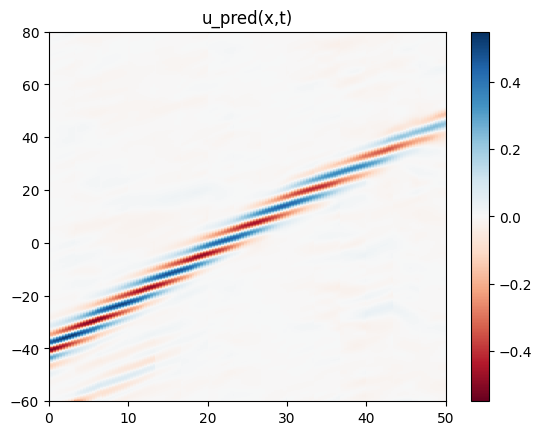

<ipython-input-45-dc463f394a6f>:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


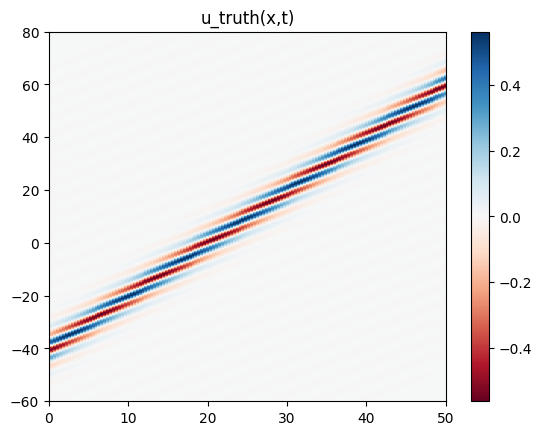

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
#plt.scatter(X_uv_train[:,1], X_uv_train[:,0], s=7, color='black')
#plt.scatter(X_f_train[:,1], X_f_train[:,0], s=3, color='black', alpha=0.3)
plt.show()

fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_truth(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

<ipython-input-46-50851ae001b5>:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)


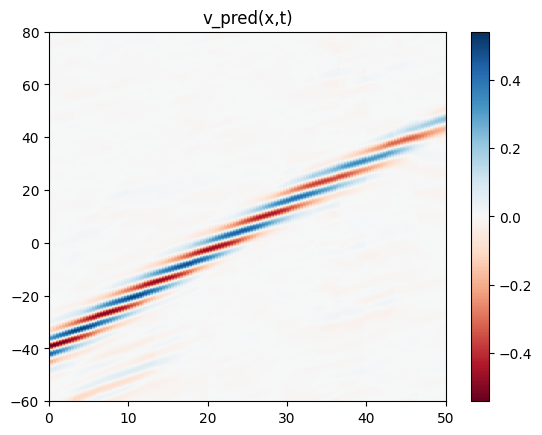

<ipython-input-46-50851ae001b5>:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


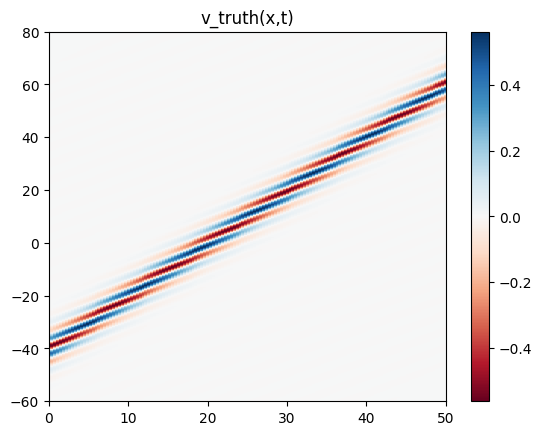

In [46]:
fig, ax = plt.subplots()
v_min, v_max = -np.abs(v_pred).max(), np.abs(v_pred).max()
c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_truth(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

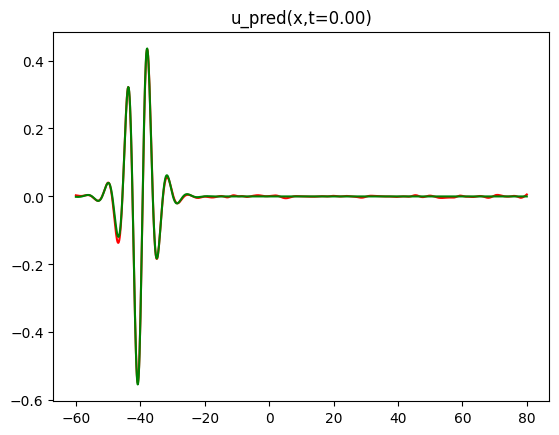

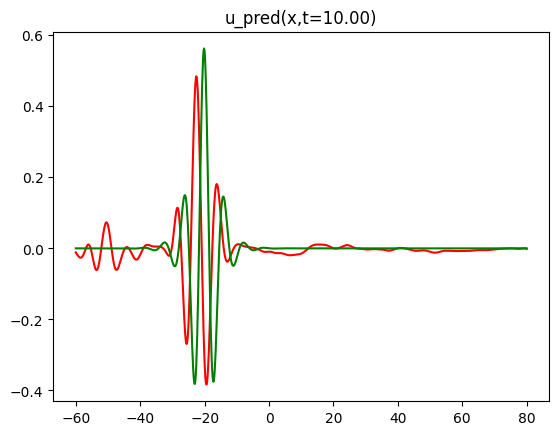

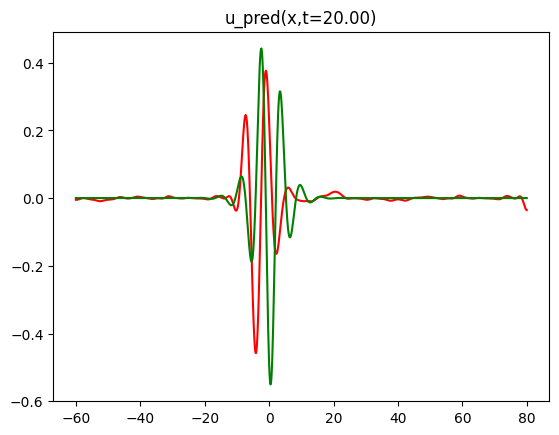

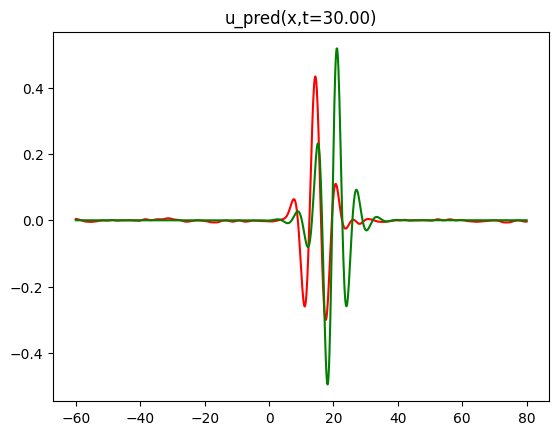

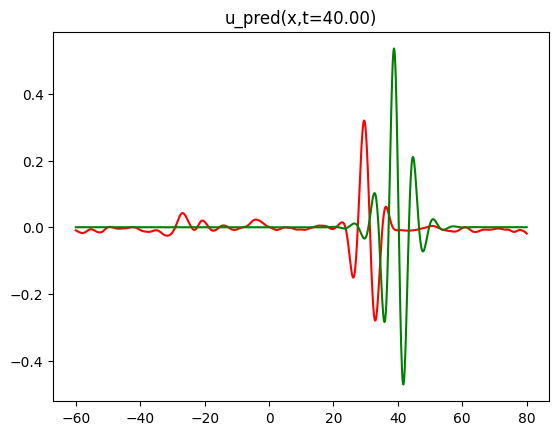

In [64]:
for t in range(t_0,t_1, 10):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  plt.plot(X[current_row, :], u_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  plt.plot(X[current_row, :], Exact_u[current_row,:], color = "green")
  plt.title('u_pred(x,t=%.2f)'%t)
  plt.show()

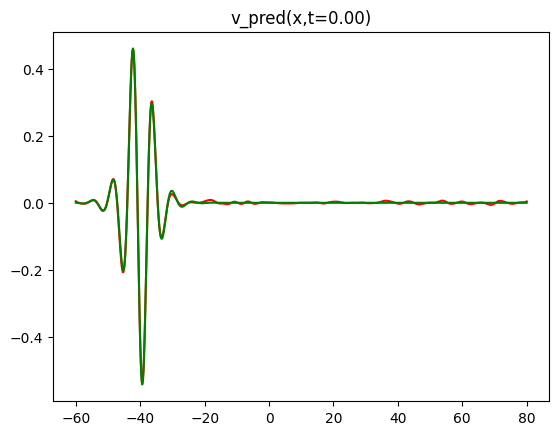

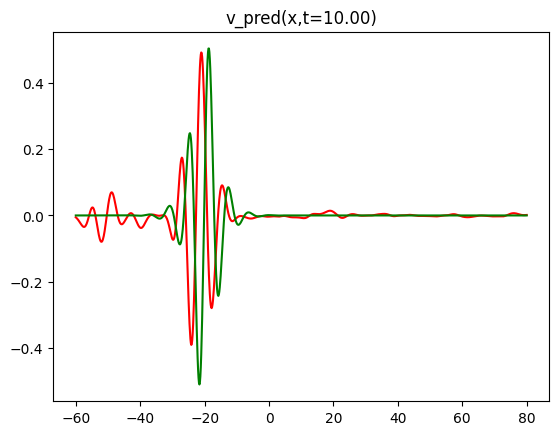

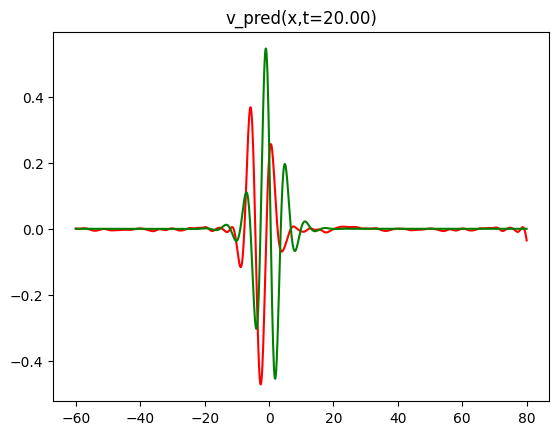

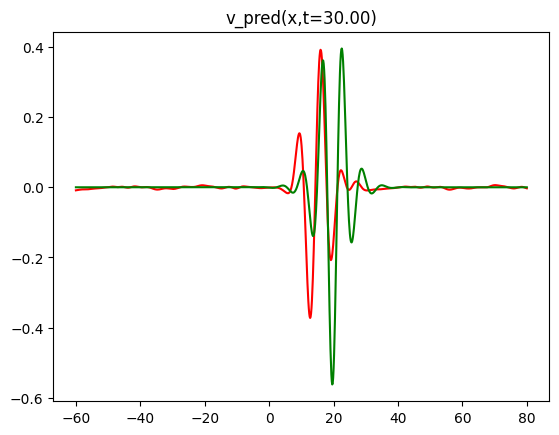

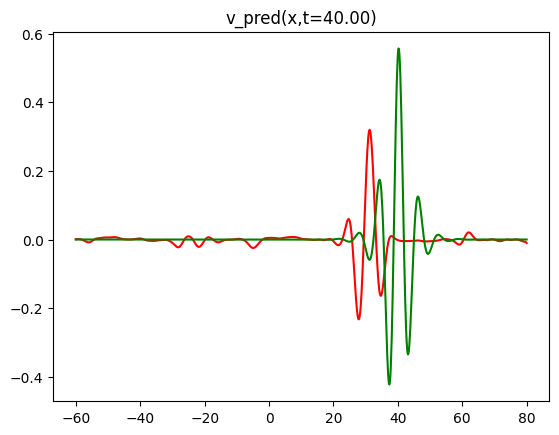

In [65]:
for t in range(t_0, t_1, 10):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  plt.plot(X[current_row, :], v_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  plt.plot(X[current_row, :], Exact_v[current_row,:], color = "green")
  plt.title('v_pred(x,t=%.2f)'%t)
  plt.show()